# Multiscale PV Recycling MILP

In [30]:
__author__ = "Natasha Jane Chrisandina, Funda Iseri"
__copyright__ = "Copyright 2023, Multi-parametric Optimization & Control Lab"
__credits__ = ["Natasha Jane Chrisandina", "Funda Iseri", "Efstratios N. Pistikopoulos"]
__license__ = "MIT"
__version__ = "1.0.0"
__maintainer__ = "Natasha Jane Chrisandina"
__email__ = "nchrisandina@tamu.edu"
__status__ = "Production"


## Problem Statement

The following case study considers one type of solar PV panel (crystalline silicon, c-Si) that is to be recycled into separate components. The goal is to maximize economic profit obtained from the recycling process.

Data source: https://www.sciencedirect.com/science/article/pii/S0927024822000162

Module imports

In [31]:
import sys
sys.path.append('src')

In [32]:
import pandas 
import numpy

from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource
from energiapy.components.process import Process
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.result import Result 
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
import matplotlib.pyplot as plt
from matplotlib import rc
from itertools import product
# from energiapy.model.constraints.integer_cuts import constraint_block_integer_cut

### Initialize model

Define temporal scales at different levels:
- 0 is annual, with 1 discretization
- 1 is daily, with 365 discretization

In [33]:
scales = TemporalScale(discretization_list=[1, 2])

Define resources, which are things to be consumed, produced, stored, or sold. In this case, the feedstock is silicon PV and the products are the different major recyclable materials. We will assume that *glass* is a product in demand, whereas everything else can simply be sold.

In [34]:
SiPV_dummy = Resource(name = 'sipv_dummy', label='Silicon PV Dummy', price=50, basis = 'module', cons_max=13000)
SiPV = Resource(name = 'sipv', label='Silicon Photovoltaic', price=50, basis = 'module')
glass = Resource(name = 'glass', label='Recycled glass', revenue=100, basis = 'kg')
aluminum = Resource(name = 'al', label='Recycled aluminum', revenue=100, basis = 'kg', sell=True)
polymer = Resource(name = 'polymer', label='Recycled polymer', revenue=100, basis = 'kg', sell=True)
copper = Resource(name = 'cu', label='Recycled copper', revenue=100, basis = 'kg', sell=True)
silver = Resource(name = 'ag', label='Recycled silver', revenue=100, basis = 'kg', sell=True)
silicon = Resource(name = 'si', label='Recycled silicon', revenue=100, basis = 'kg', sell=True)
glass_dummy = Resource(name = 'glass_dummy', label='Recycled glass Dummy', revenue=100, basis = 'kg', demand=True)


Define processes, which are the different potential recycling processes. There are three types of process: FRELP, ASU, and Hybrid, and each process has two separate max production level to represent large-scale vs small-scale recycling.

The "collection" process is essentially a dummy process to represent PVs being shipped off from a collection center to recycling center locations. Glass_collect is the same, except for glass which is a demanded product

In [35]:
collection = Process(name = 'collection', label='dummy process', conversion = {SiPV_dummy: -1, SiPV: 1}, prod_max = 130000, capex = 0.001)
glass_collect = Process(name = 'glass_collection', label='dummy process for product', conversion = {glass: -1, glass_dummy: 1}, prod_max = 10**6, capex = 0.001)


FRELP = Process(name = 'FRELP', label='FRELP recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.17945, silver: 0.001739}, prod_max = 1300, capex = 4, vopex = 8, block='A')
ASU = Process(name = 'ASU', label='ASU recycling', conversion = {SiPV: -1, glass: 13.73625, polymer: 2.22, aluminum: 1.5651, silicon: 0.4995, copper: 0.15355, silver: 0.001369}, prod_max = 1300, prod_min = 1, capex = 17, vopex = 9, block='A')
hybrid = Process(name = 'hybrid', label='Hybrid recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.15355, silver: 0.001369}, prod_max = 1300, capex = 3, vopex = 7, block='A')


FRELP_big = Process(name = 'FRELP_big', label='big FRELP recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.17945, silver: 0.001739}, prod_max = 13000, capex = 3, vopex = 5, block='A')
ASU_big = Process(name = 'ASU_big', label='big ASU recycling', conversion = {SiPV: -1, glass: 13.73625, polymer: 2.22, aluminum: 1.5651, silicon: 0.4995, copper: 0.15355, silver: 0.001369}, prod_max = 13000, capex = 8, vopex = 6, block='A')
hybrid_big = Process(name = 'hybrid_big', label='big Hybrid recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.15355, silver: 0.001369}, prod_max = 13000, capex = 3, vopex = 4, block='A')


Define locations

In [36]:
cc1 = Location(name='cc1', label = 'Collection Center 1', scales = scales, processes = {collection})
cc2 = Location(name='cc2', label = 'Collection Center 2', scales = scales, processes = {collection})


rc1 = Location(name='rc1', label = 'Recycling Center 1', scales = scales, processes = {FRELP, ASU, hybrid, FRELP_big, ASU_big, hybrid_big})

gc1 = Location(name='gc1', label = 'Glass Recycling Center 1', scales = scales, processes= {glass_collect})


Define transportation modes

In [37]:
Trans_pvs = Transport(name = 'Trans_PV', resources = {SiPV}, trans_max = 10**6, trans_cost = 0.01, label = 'Transport of PVs')
Trans_rec = Transport(name = 'Trans_rec', resources = {glass}, trans_max = 10**6, trans_cost = 0.01, label = 'Transport for recycled materials')


distance_matrix = [
    [100, 200],
    [100, 200],
    [0, 100]
    ]

transport_matrix = [
    [[Trans_pvs], []],
    [[Trans_pvs], []],
    [[], [Trans_rec]]
]


network = Network(name = 'Network', label= 'Generic network', source_locations = [cc1, cc2, rc1], sink_locations = [rc1, gc1], distance_matrix = distance_matrix, transport_matrix= transport_matrix)

Define scenario. Glass recycling center has some level of demand that needs fulfilling

In [38]:
genericScenario = Scenario(name = 'genericScenario', network = network, scales= scales, demand={gc1: {glass_dummy: 10000}, rc1: {glass_dummy: 0}}, label = 'genericScenario', network_scale_level = 0, purchase_scale_level = 1, scheduling_scale_level = 1, demand_scale_level = 1, expenditure_scale_level = 0)

MILP formulation. Objective: meet demand at minimum cost

In [39]:
milp_demand = formulate(scenario = genericScenario, constraints={Constraints.INVENTORY, Constraints.COST, Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE, Constraints.TRANSPORT, Constraints.NETWORK}, objective=Objective.COST)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint location vopex
constraint location incidental
constraint network capex
constraint network fopex
constraint network vopex
constraint network incidental
constraint nameplate inventory
constraint storage max
constraint storage min
constraint production mode
constraint nameplate production
constraint production max
constraint production min
constraint inventory balance
constraint resource consumption
constraint resource purchase
constraint location production
constraint location discharge
constraint location consumption
constraint location purchase
constraint network production
constraint network discharge
constraint network consumption
constraint network purchase
constraint transport export
constraint transport import
constraint transport exp UB
constraint transport imp UB
constraint transport balance
constraint transport i

In [40]:
# milp_demand = formulate(scenario = genericScenario, constraints={Constraints.INVENTORY, Constraints.COST, Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE, Constraints.TRANSPORT, Constraints.NETWORK}, objective=Objective.MAX_DISCHARGE, objective_resource = glass_dummy)

Specify that only one process gets chosen in RC1

Integer cut constraints can also be used to indicate that we need at least/at most X many processes in this location

In [41]:
# milp_demand.constraint_block_integer_cut1 = constraint_block_integer_cut(
#     instance=milp_demand, network_scale_level=0, location=rc1, block='A', number=1, process_set=rc1.processes)

In [42]:
# results = solve(scenario = genericScenario, instance=milp_demand, solver='BARON', interface= 'gams', print_solversteps=True, name = 'results')

In [43]:
results = solve(scenario = genericScenario, instance=milp_demand, solver='gurobi', print_solversteps=True, name = 'results')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 766 rows, 743 columns and 1810 nonzeros
Model fingerprint: 0xf8d5cbe6
Variable types: 699 continuous, 44 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 1e+06]
Presolve removed 761 rows and 733 columns
Presolve time: 0.00s
Presolved: 5 rows, 10 columns, 20 nonzeros
Variable types: 9 continuous, 1 integer (1 binary)
Found heuristic solution: objective 103114.24710

Root relaxation: cutoff, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0

In [44]:
results.output['S_network']

{('polymer', 0): 3265.3061224489797,
 ('glass_dummy', 0): 20000.0,
 ('cu', 0): 225.8503401360544,
 ('si', 0): 791.8367346938775,
 ('al', 0): 2434.285714285714,
 ('ag', 0): 2.0136054421768708}

In [45]:
genericScenario.make_conversion_df()

,glass,polymer,glass_dummy,sipv,cu,sipv_dummy,si,al,ag
FRELP,13.59750,2.22,0.0,-1.0,0.17945,0.0,0.53835,1.65501,0.001739
glass_collection,-1.00000,0.00,1.0,0.0,0.00000,0.0,0.00000,0.00000,0.000000
ASU,13.73625,2.22,0.0,-1.0,0.15355,0.0,0.49950,1.56510,0.001369
hybrid_big,13.59750,2.22,0.0,-1.0,0.15355,0.0,0.53835,1.65501,0.001369
FRELP_big,13.59750,2.22,0.0,-1.0,0.17945,0.0,0.53835,1.65501,0.001739
hybrid,13.59750,2.22,0.0,-1.0,0.15355,0.0,0.53835,1.65501,0.001369
ASU_big,13.73625,2.22,0.0,-1.0,0.15355,0.0,0.49950,1.56510,0.001369
collection,0.00000,0.00,0.0,1.0,0.00000,-1.0,0.00000,0.00000,0.000000


In [57]:
results.output['Cap_P']


{('gc1', 'FRELP', 0): 0.0,
 ('gc1', 'glass_collection', 0): 10000.0,
 ('gc1', 'ASU', 0): 0.0,
 ('gc1', 'hybrid_big', 0): 0.0,
 ('gc1', 'FRELP_big', 0): 0.0,
 ('gc1', 'hybrid', 0): 0.0,
 ('gc1', 'ASU_big', 0): 0.0,
 ('gc1', 'collection', 0): 0.0,
 ('rc1', 'FRELP', 0): 0.0,
 ('rc1', 'glass_collection', 0): 0.0,
 ('rc1', 'ASU', 0): 0.0,
 ('rc1', 'hybrid_big', 0): 735.4293068578783,
 ('rc1', 'FRELP_big', 0): 0.0,
 ('rc1', 'hybrid', 0): 0.0,
 ('rc1', 'ASU_big', 0): 0.0,
 ('rc1', 'collection', 0): 0.0,
 ('cc2', 'FRELP', 0): 0.0,
 ('cc2', 'glass_collection', 0): 0.0,
 ('cc2', 'ASU', 0): 0.0,
 ('cc2', 'hybrid_big', 0): 0.0,
 ('cc2', 'FRELP_big', 0): 0.0,
 ('cc2', 'hybrid', 0): 0.0,
 ('cc2', 'ASU_big', 0): 0.0,
 ('cc2', 'collection', 0): 367.71465342893913,
 ('cc1', 'FRELP', 0): 0.0,
 ('cc1', 'glass_collection', 0): 0.0,
 ('cc1', 'ASU', 0): 0.0,
 ('cc1', 'hybrid_big', 0): 0.0,
 ('cc1', 'FRELP_big', 0): 0.0,
 ('cc1', 'hybrid', 0): 0.0,
 ('cc1', 'ASU_big', 0): 0.0,
 ('cc1', 'collection', 0): 367.

In [47]:
milp_demand.constraint_production_facility.pprint()

constraint_production_facility : production facility sizing and location
    Size=32, Index=constraint_production_facility_index, Active=True
    Key                            : Lower : Body                                                                : Upper : Active
                 ('cc1', 'ASU', 0) :   0.0 :                                                    Cap_P[cc1,ASU,0] :   0.0 :   True
             ('cc1', 'ASU_big', 0) :   0.0 :                                                Cap_P[cc1,ASU_big,0] :   0.0 :   True
               ('cc1', 'FRELP', 0) :   0.0 :                                                  Cap_P[cc1,FRELP,0] :   0.0 :   True
           ('cc1', 'FRELP_big', 0) :   0.0 :                                              Cap_P[cc1,FRELP_big,0] :   0.0 :   True
          ('cc1', 'collection', 0) :  -Inf :              Cap_P[cc1,collection,0] - 130000*X_P[cc1,collection,0] :   0.0 :   True
    ('cc1', 'glass_collection', 0) :   0.0 :                                  

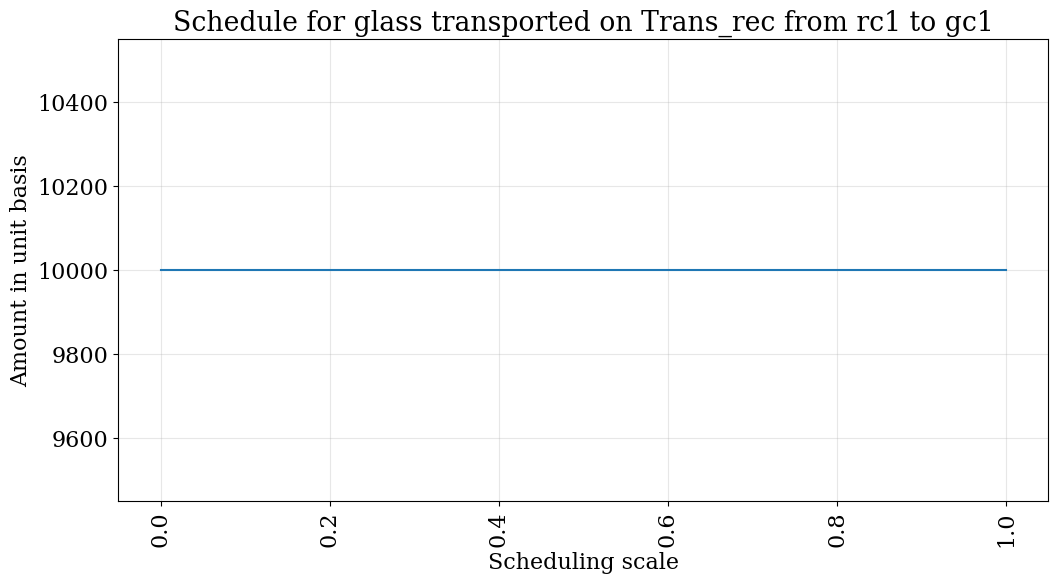

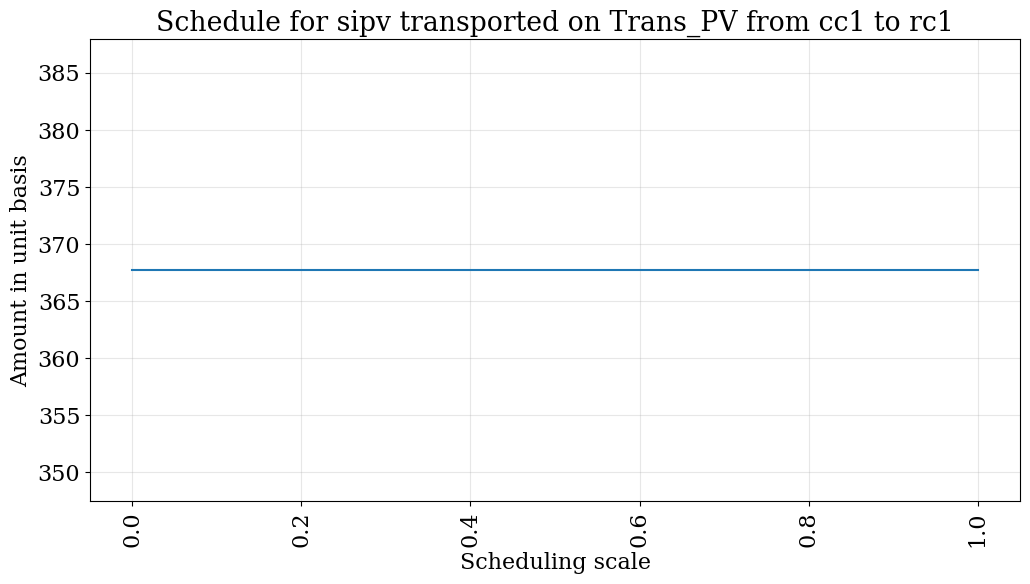

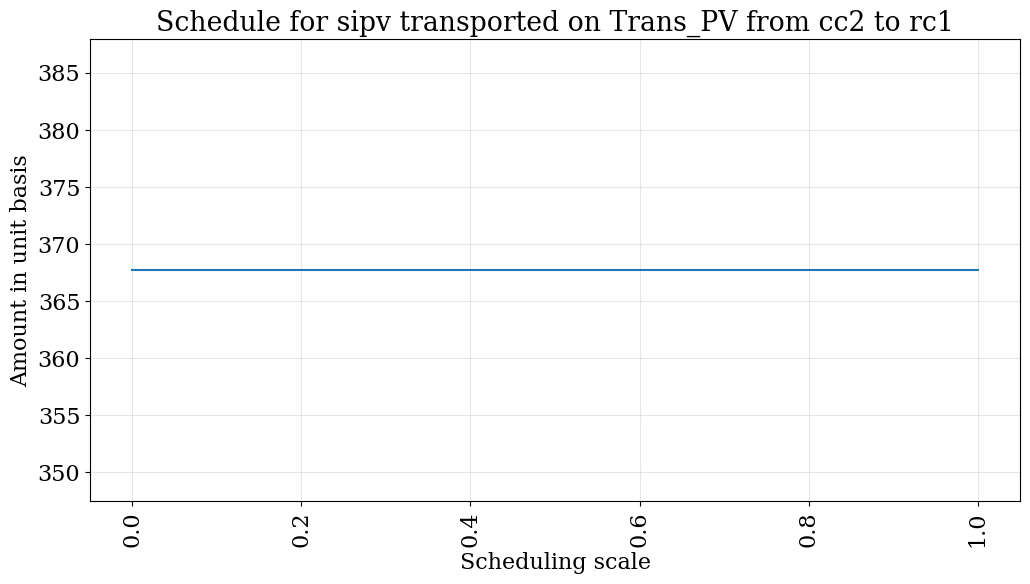

In [62]:
plot_results.transport(results= results, source= 'rc1', sink = 'gc1', resource= 'glass', transport = 'Trans_rec')
plot_results.transport(results= results, source= 'cc1', sink = 'rc1', resource= 'sipv', transport = 'Trans_PV')
plot_results.transport(results= results, source= 'cc2', sink = 'rc1', resource= 'sipv', transport = 'Trans_PV')


In [63]:
genericScenario.transport_dict

{('cc1', 'rc1'): {Trans_PV},
 ('cc1', 'gc1'): set(),
 ('cc2', 'rc1'): {Trans_PV},
 ('cc2', 'gc1'): set(),
 ('rc1', 'rc1'): set(),
 ('rc1', 'gc1'): {Trans_rec}}

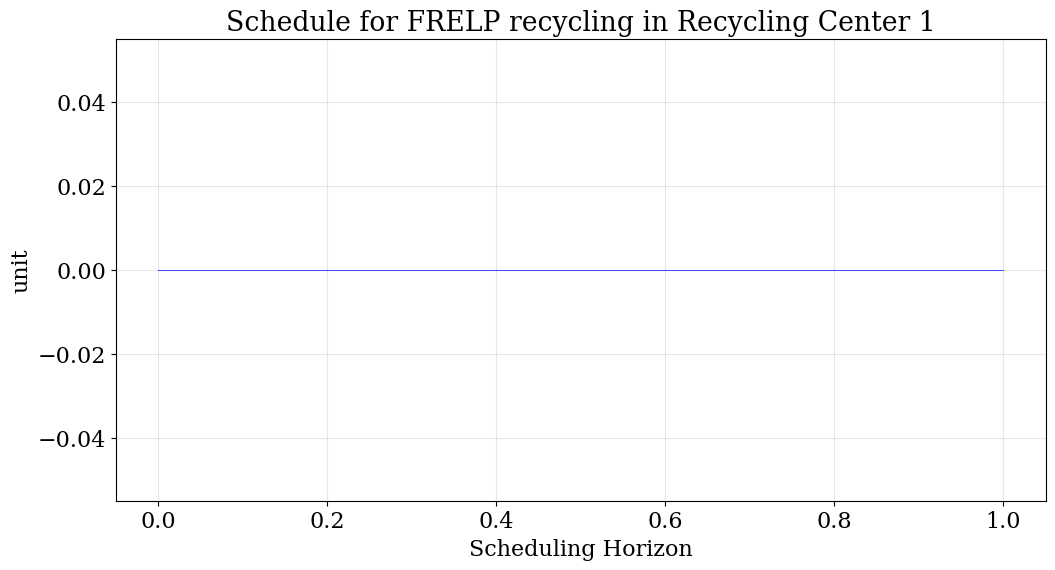

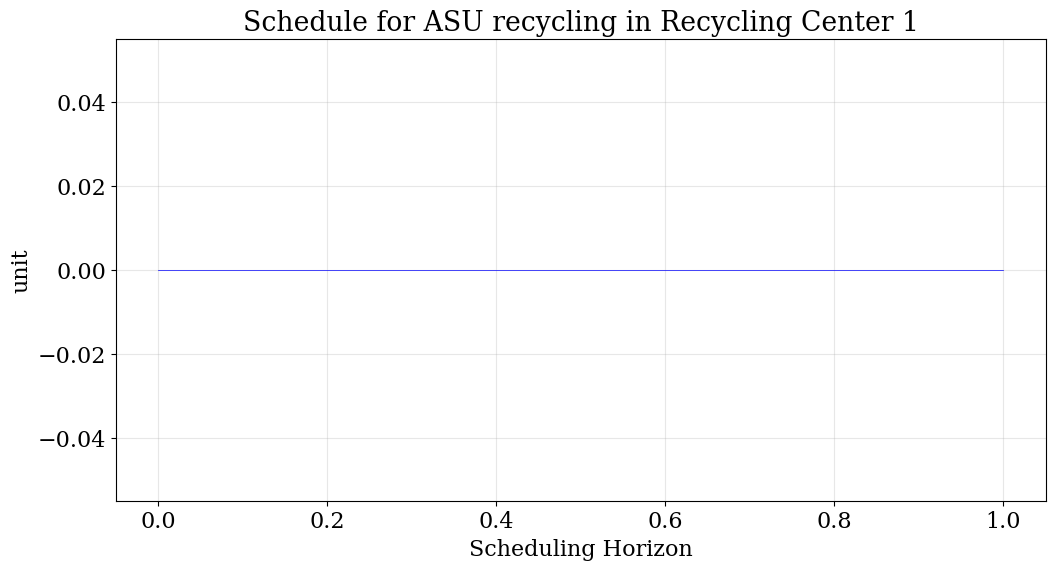

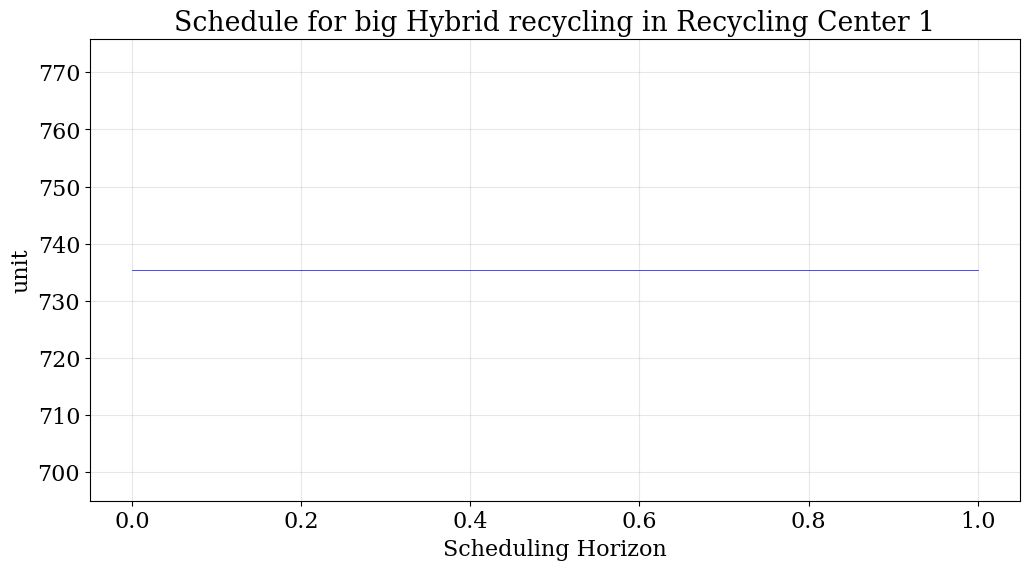

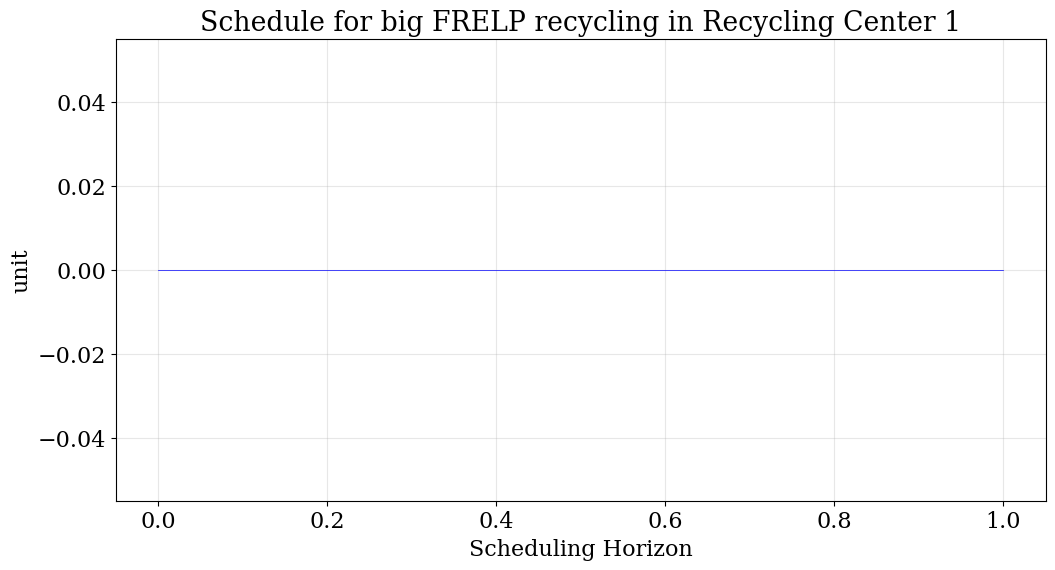

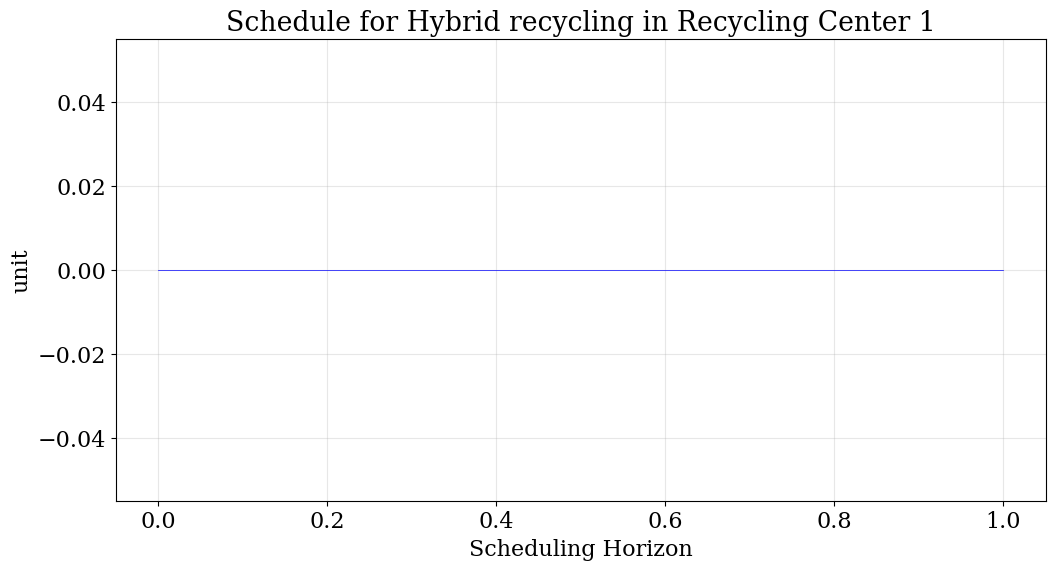

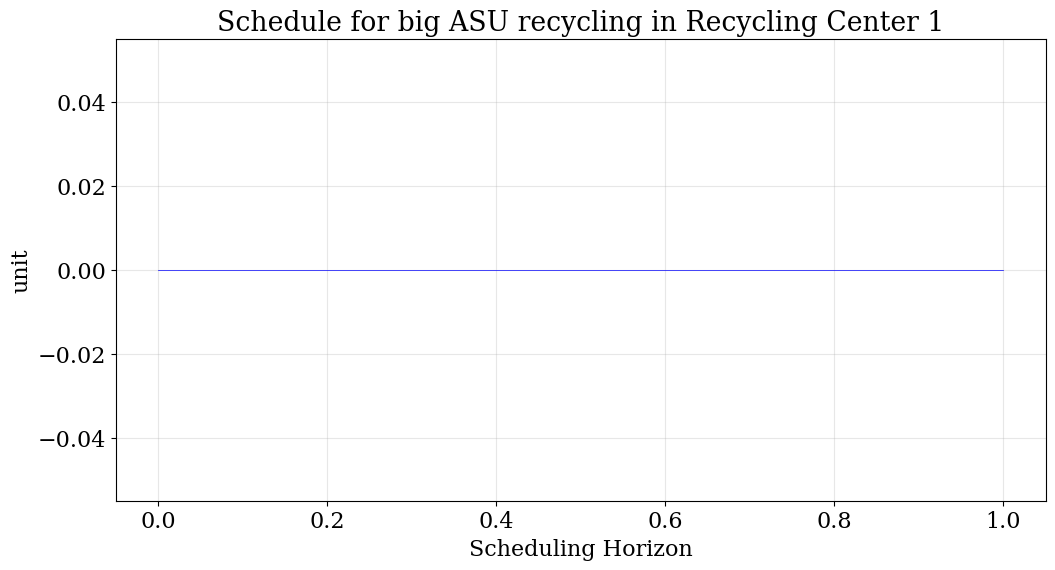

In [50]:
for i in {FRELP, ASU, hybrid, FRELP_big, ASU_big, hybrid_big}:
    plot_results.schedule(location = 'rc1', component = i.name, results = results, y_axis = 'P')

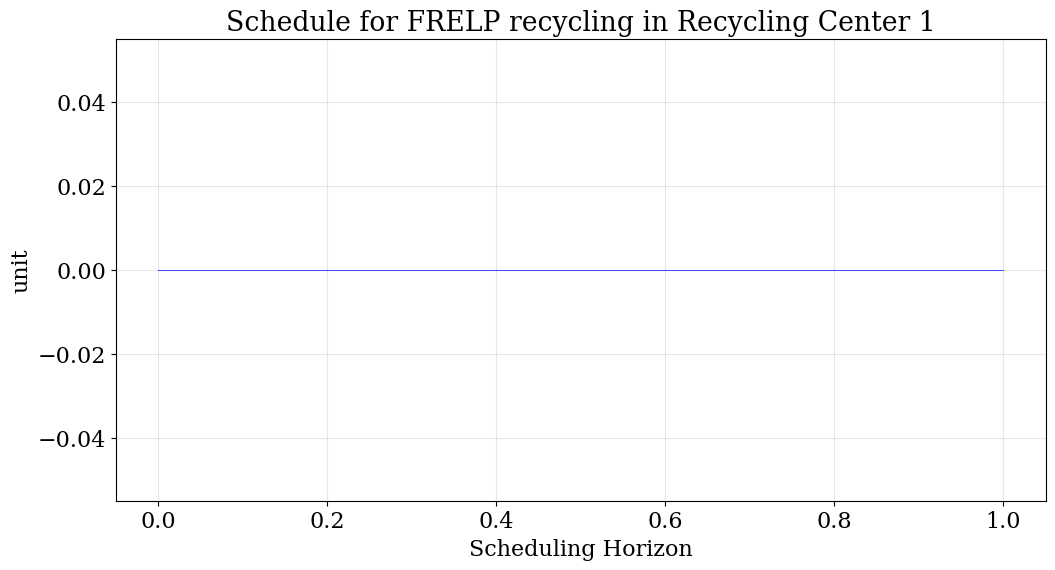

In [51]:
plot_results.schedule(location = 'rc1', component = 'FRELP', results = results, y_axis = 'P')

In [52]:
results.output['Cap_P']

{('gc1', 'FRELP', 0): 0.0,
 ('gc1', 'glass_collection', 0): 10000.0,
 ('gc1', 'ASU', 0): 0.0,
 ('gc1', 'hybrid_big', 0): 0.0,
 ('gc1', 'FRELP_big', 0): 0.0,
 ('gc1', 'hybrid', 0): 0.0,
 ('gc1', 'ASU_big', 0): 0.0,
 ('gc1', 'collection', 0): 0.0,
 ('rc1', 'FRELP', 0): 0.0,
 ('rc1', 'glass_collection', 0): 0.0,
 ('rc1', 'ASU', 0): 0.0,
 ('rc1', 'hybrid_big', 0): 735.4293068578783,
 ('rc1', 'FRELP_big', 0): 0.0,
 ('rc1', 'hybrid', 0): 0.0,
 ('rc1', 'ASU_big', 0): 0.0,
 ('rc1', 'collection', 0): 0.0,
 ('cc2', 'FRELP', 0): 0.0,
 ('cc2', 'glass_collection', 0): 0.0,
 ('cc2', 'ASU', 0): 0.0,
 ('cc2', 'hybrid_big', 0): 0.0,
 ('cc2', 'FRELP_big', 0): 0.0,
 ('cc2', 'hybrid', 0): 0.0,
 ('cc2', 'ASU_big', 0): 0.0,
 ('cc2', 'collection', 0): 367.71465342893913,
 ('cc1', 'FRELP', 0): 0.0,
 ('cc1', 'glass_collection', 0): 0.0,
 ('cc1', 'ASU', 0): 0.0,
 ('cc1', 'hybrid_big', 0): 0.0,
 ('cc1', 'FRELP_big', 0): 0.0,
 ('cc1', 'hybrid', 0): 0.0,
 ('cc1', 'ASU_big', 0): 0.0,
 ('cc1', 'collection', 0): 367.

In [53]:
genericScenario.distance_dict

{('cc1', 'rc1'): 100,
 ('cc1', 'gc1'): 200,
 ('cc2', 'rc1'): 100,
 ('cc2', 'gc1'): 200,
 ('rc1', 'rc1'): 0,
 ('rc1', 'gc1'): 100}

In [54]:
milp_demand.constraint_nameplate_production.pprint()

constraint_nameplate_production : nameplate production capacity constraint
    Size=64, Index=constraint_nameplate_production_index, Active=True
    Key                               : Lower : Body                                                        : Upper : Active
                 ('cc1', 'ASU', 0, 0) :   0.0 :                                              P[cc1,ASU,0,0] :   0.0 :   True
                 ('cc1', 'ASU', 0, 1) :   0.0 :                                              P[cc1,ASU,0,1] :   0.0 :   True
             ('cc1', 'ASU_big', 0, 0) :   0.0 :                                          P[cc1,ASU_big,0,0] :   0.0 :   True
             ('cc1', 'ASU_big', 0, 1) :   0.0 :                                          P[cc1,ASU_big,0,1] :   0.0 :   True
               ('cc1', 'FRELP', 0, 0) :   0.0 :                                            P[cc1,FRELP,0,0] :   0.0 :   True
               ('cc1', 'FRELP', 0, 1) :   0.0 :                                            P[cc1,FRELP,0,

In [55]:
milp_demand.constraint_production_facility.pprint()

constraint_production_facility : production facility sizing and location
    Size=32, Index=constraint_production_facility_index, Active=True
    Key                            : Lower : Body                                                                : Upper : Active
                 ('cc1', 'ASU', 0) :   0.0 :                                                    Cap_P[cc1,ASU,0] :   0.0 :   True
             ('cc1', 'ASU_big', 0) :   0.0 :                                                Cap_P[cc1,ASU_big,0] :   0.0 :   True
               ('cc1', 'FRELP', 0) :   0.0 :                                                  Cap_P[cc1,FRELP,0] :   0.0 :   True
           ('cc1', 'FRELP_big', 0) :   0.0 :                                              Cap_P[cc1,FRELP_big,0] :   0.0 :   True
          ('cc1', 'collection', 0) :  -Inf :              Cap_P[cc1,collection,0] - 130000*X_P[cc1,collection,0] :   0.0 :   True
    ('cc1', 'glass_collection', 0) :   0.0 :                                  

In [56]:
milp_demand.constraint_inventory_balance.pprint()

constraint_inventory_balance : mass balance across scheduling scale
    Size=72, Index=constraint_inventory_balance_index, Active=True
    Key                          : Lower : Body                                                                                                                                                                                                                                                                                                             : Upper : Active
             ('cc1', 'ag', 0, 0) :   0.0 :                                                                                          0.001739*P_m[cc1,FRELP,0,0,0] + 0.001369*P_m[cc1,ASU,0,0,0] + 0.001369*P_m[cc1,hybrid_big,0,0,0] + 0.001739*P_m[cc1,FRELP_big,0,0,0] + 0.001369*P_m[cc1,hybrid,0,0,0] + 0.001369*P_m[cc1,ASU_big,0,0,0] - S[cc1,ag,0,0] :   0.0 :   True
             ('cc1', 'ag', 0, 1) :   0.0 :                                                                                          0.0